In [1]:
using JSON
using HTML_Entities
using StrTables
using StringEncodings
using Unicode
using Plots

In [2]:
API_Tweets = Dict()
open("Twitter_API_tweets.json", "r") do f
    global API_Tweets
    dicttxt = read(f,String)  # file information to string
    API_Tweets=JSON.parse(dicttxt)  # parse and transform data
end


Dict{String,Any} with 6 entries:
  "Twitter Error" => Any["Two thousand years of error? Pope Francis moves close…
  "Emoji"         => Any["me, tryna tell jae jyp spent over 1M on the emoji:\n\…
  "Zango Text"    => Any[]
  "Unicode"       => Any["Soon to be added to https://t.co/VUHHW9p7dN! Yi Sylla…
  "Tweet Error"   => Any["RT @del_bangtan: BB has become the Allkpp and Kboo of…
  "Emoticons"     => Any["who's the anon flirting with papi....... pLs stop the…

In [3]:
KAGGLE_Tweets_Emoji_Competition = []

for line in eachline(open("tweets_emoji_competition.txt"))
    push!(KAGGLE_Tweets_Emoji_Competition, line)
end

KAGGLE_Tweets_User_Jan = []

for line in eachline(open("tweets_user_jan_2019.txt"))
    push!(KAGGLE_Tweets_User_Jan, line)
end



In [4]:
const EMOTICONS_REGEX = r"""(?x)
            (?:
             [<>]?
             [:;=8]
             [\-o\*\']?
             [\)\]\(\[dDpP/\:\}\{@\|\\]
             |
             [\)\]\(\[dDpP/\:\}\{@\|\\]
             [\-o\*\']?
             [:;=8]
             [<>]?
             |
             <3
            )"""


const URLS = r"""(?ix)
        (?:
        https?:
          (?:
            /{1,3}
            |
            [a-z0-9%]
          )
          |
          [a-z0-9.\-]+[.]
          (?:[a-z]{2,13})
          /
        )
        (?:
          [^\s()<>{}\[\]]+
          |
          \([^\s()]*?\([^\s()]+\)[^\s()]*?\)
          |
          \([^\s]+?\)
        )+
        (?:
          \([^\s()]*?\([^\s()]+\)[^\s()]*?\)
          |
          \([^\s]+?\)
          |
          [^\s`!()\[\]{};:'".,<>?«»“”‘’]
        )
        |
        (?:
                (?<!@)
          [a-z0-9]+
          (?:[.\-][a-z0-9]+)*
          [.]
          (?:[a-z]{2,13})
          \b
          /?
          (?!@)
        )
      """


const PHONE_NUMBERS = r"""(?x)
           (?:
             (?:
               \+?[01]
               [ *\-.\)]*
             )?
             (?:
               [\(]?
               \d{3}
               [ *\-.\)]*
             )?
             \d{3}
             [ *\-.\)]*
             \d{4}
           )"""


const HTML_TAGS = r"""<[^>\s]+>"""
const ASCII_ARROWS = r"""[\-]+>|<[\-]+"""
const TWITTER_USERNAME = r"""(?:@[\w_]+)"""
const TWITTER_HASHTAGS = r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"""
const EMAIL_ADDRESSES = r"""[\w.+-]+@[\w-]+\.(?:[\w-]\.?)+[\w-]"""
const WORDS_WITH_APOSTROPHE_DASHES = r"""(?:[^\W\d_](?:[^\W\d_]|['\-_])+[^\W\d_])"""
const NUMBERS_FRACTIONS_DECIMALS = r"""(?:[+\-]?\d+[,/.:-]\d+[+\-]?)"""
const ELLIPSIS_DOTS = r"""(?:\.(?:\s*\.){1,})"""
const WORDS_WITHOUT_APOSTROPHE_DASHES = r"""(?:[\w_]+)"""




const WORD_REGEX = Regex("(?i:" * join([URLS.pattern
                        PHONE_NUMBERS.pattern
                        EMOTICONS_REGEX.pattern
                        HTML_TAGS.pattern
                        ASCII_ARROWS.pattern
                        TWITTER_USERNAME.pattern
                        TWITTER_HASHTAGS.pattern
                        EMAIL_ADDRESSES.pattern
                        WORDS_WITH_APOSTROPHE_DASHES.pattern
                        NUMBERS_FRACTIONS_DECIMALS.pattern
                        WORDS_WITHOUT_APOSTROPHE_DASHES.pattern
                        ELLIPSIS_DOTS.pattern
                        r"(?:\S)".pattern
                        ], "|")
                        * ")"
                    )


const HANG_REGEX = r"""([^a-zA-Z0-9])\1{3,}"""

const HTML_ENTITIES_REGEX = r"""&(#?(x?))([^&;\s]+);"""

const HANDLES_REGEX = r"""(?x)
                (?<![A-Za-z0-9_!@#\$%&*])@(([A-Za-z0-9_]){20}(?!@))
                |
                (?<![A-Za-z0-9_!@#\$%&*])@(([A-Za-z0-9_]){1,19})(?![A-Za-z0-9_]*@)
                """


r"(?x)
(?<![A-Za-z0-9_!@#\$%&*])@(([A-Za-z0-9_]){20}(?!@))
|
(?<![A-Za-z0-9_!@#\$%&*])@(([A-Za-z0-9_]){1,19})(?![A-Za-z0-9_]*@)
"

In [5]:
"""
    replace_html_entities(input_text::AbstractString,
                    remove_illegal=true) => (entities_replaced_text::AbstractString)

Removes entities from text by converting them to their corresponding unicode character.
"""
function replace_html_entities(input_text::AbstractString; remove_illegal=true)

    function convert_entity(matched_text)
        # HTML entity can be named or encoded in Decimal/Hex form
        # - Named_entity : "&Delta;" => "Δ",
        # - Decimal : "&#916;" => "Δ",
        # - Hex : "&#x394;" => "Δ",
        #
        # However for bytes (hex) 80-9f are interpreted in Windows-1252
        is_numeric_encoded, is_hex_encoded, entity_text = match(HTML_ENTITIES_REGEX,
                                                matched_text).captures
        number = -1

        if isempty(is_numeric_encoded) 
            return lookupname(HTML_Entities.default, entity_text)
        else
            if isempty(is_hex_encoded) 
                is_numeric = all(isdigit, entity_text)
                if is_numeric
                    number = parse(Int, entity_text, base=10)
                end
            else
                base_16_letters = ('a', 'b', 'c', 'd', 'e', 'f')
                is_base_16 = all(entity_text) do i
                    isdigit(i) || i in base_16_letters
                end
                if is_base_16
                    number = parse(Int, entity_text, base=16)
                end
            end

            # Numeric character references in the 80-9F range are typically
            # interpreted by browsers as representing the characters mapped
            # to bytes 80-9F in the Windows-1252 encoding. For more info
            # see: https://en.wikipedia.org/wiki/ISO/IEC_8859-1#Similar_character_sets

            if number >= 0
                if 0x80 <= number <= 0x9F 
                    if number ∉ (129, 141, 143, 144, 157) 
                        return decode([UInt8(number)], "WINDOWS-1252")
                    end
                elseif Unicode.isassigned(number)
                        return Char(number)
                end
            end
        end

        if remove_illegal
            return ""
        else
            return matched_text
        end
    end

    entities_replaced_text = replace(input_text, HTML_ENTITIES_REGEX => convert_entity)
    return entities_replaced_text
end


replace_html_entities

In [6]:
"""
    The key tokenizing function.
"""
function tweet_tokenize(source::AbstractString;
                            strip_handle=false,
                            reduce_len=false,
                            preserve_case=true)


    # Fix HTML Character entities
        source = replace_html_entities(source)

    if strip_handle
        source = replace(source, HANDLES_REGEX => " ")
    end

    if reduce_len
        source = replace(source, r"(.)\1{2,}" => s"\1\1\1")
    end

    safe_text = replace(source, r"""([^a-zA-Z0-9])\1{3,}""" => s"\1\1\1")


    tokens = collect((m.match for m in eachmatch(WORD_REGEX,
                                            safe_text,
                                            overlap=false)))

    if  !preserve_case
        for (index, word) in enumerate(tokens)
            if !occursin(EMOTICONS_REGEX, word)
                tokens[index] = lowercase(word)
            end
        end
    end

    return tokens
end


tweet_tokenize

In [7]:
function cnt(tokens, parameter, params_list)
    for token in tokens
        matched = 0
        for param in params_list
            patt = Regex("^" * eval(Meta.parse(param)).pattern * r"$".pattern)
            m = match(patt, token)
            if m != nothing && length(match(patt, token).match) == length(token)
                parameter[param] += 1
                matched = 1
                break 
            end
        end
    end
end

cnt (generic function with 1 method)

In [19]:
"""
The Following Regex are being considered: 
1.  URLS
2.  PHONE_NUMBERS
3.  EMOTICONS_REGEX
4.  HTML_TAGS
5.  ASCII_ARROWS
6.  TWITTER_USERNAME
7.  TWITTER_HASHTAGS
8.  EMAIL_ADDRESSES
9.  WORDS_WITH_APOSTROPHE_DASHES
10. NUMBERS_FRACTIONS_DECIMALS
11. WORDS_WITHOUT_APOSTROPHE_DASHES
12. ELLIPSIS_DOTS
"""
parameter = Dict{String,Number}()
params_list = ["URLS" "PHONE_NUMBERS" "EMOTICONS_REGEX" "HTML_TAGS" "ASCII_ARROWS" "TWITTER_USERNAME" "TWITTER_HASHTAGS" "EMAIL_ADDRESSES" "WORDS_WITH_APOSTROPHE_DASHES" "NUMBERS_FRACTIONS_DECIMALS" "WORDS_WITHOUT_APOSTROPHE_DASHES" "ELLIPSIS_DOTS"]

function reset_parameter(parameter::Dict{String,Number},params_list)
    for param in params_list
        parameter[param] = 0
    end
end

reset_parameter(parameter, params_list)


x_label = [1 2 3 4 5 6 7 8 9 10 11 12]


frequency_list = Meta.parse("""[parameter["URLS"] parameter["PHONE_NUMBERS"] parameter["EMOTICONS_REGEX"] parameter["HTML_TAGS"] parameter["ASCII_ARROWS"] parameter["TWITTER_USERNAME"] parameter["TWITTER_HASHTAGS"] parameter["EMAIL_ADDRESSES"] parameter["WORDS_WITH_APOSTROPHE_DASHES"] parameter["NUMBERS_FRACTIONS_DECIMALS"] parameter["WORDS_WITHOUT_APOSTROPHE_DASHES"] parameter["ELLIPSIS_DOTS"]]""")

eval(frequency_list)

1×12 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0  0  0  0

Dict{String,Number}("ASCII_ARROWS"=>16,"PHONE_NUMBERS"=>16,"TWITTER_USERNAME"=>3,"HTML_TAGS"=>11,"TWITTER_HASHTAGS"=>1783,"URLS"=>2006,"ELLIPSIS_DOTS"=>502,"EMAIL_ADDRESSES"=>5,"WORDS_WITH_APOSTROPHE_DASHES"=>69635,"EMOTICONS_REGEX"=>119,"WORDS_WITHOUT_APOSTROPHE_DASHES"=>22586,"NUMBERS_FRACTIONS_DECIMALS"=>128)


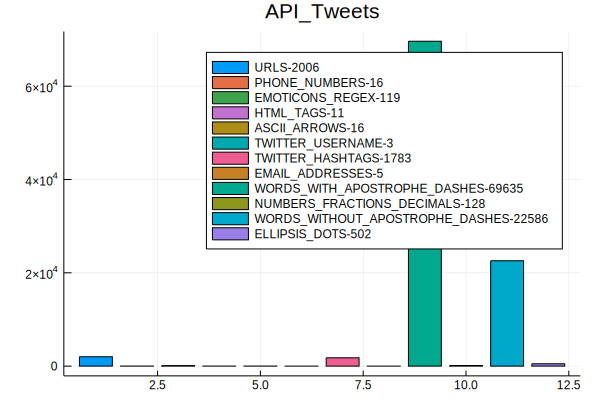

In [28]:
###########################################################################

########################## Count on API_Tweets ############################

###########################################################################

reset_parameter(parameter, params_list)

for key in keys(API_Tweets)
#     println(typeof(API_Tweets[key]))
    for tweet in API_Tweets[key]
        tokens = tweet_tokenize(tweet,strip_handle=true,reduce_len=true)
        cnt(tokens, parameter, params_list)
    end
end

println(parameter)
bar(x_label, eval(frequency_list), label=[m*"-"*string(parameter[m]) for m in params_list], title = "API_Tweets")

Dict{String,Number}("ASCII_ARROWS"=>29,"PHONE_NUMBERS"=>59,"TWITTER_USERNAME"=>89,"HTML_TAGS"=>0,"TWITTER_HASHTAGS"=>71828,"URLS"=>572,"ELLIPSIS_DOTS"=>6024,"EMAIL_ADDRESSES"=>11,"WORDS_WITH_APOSTROPHE_DASHES"=>532739,"EMOTICONS_REGEX"=>382,"WORDS_WITHOUT_APOSTROPHE_DASHES"=>134865,"NUMBERS_FRACTIONS_DECIMALS"=>1045)


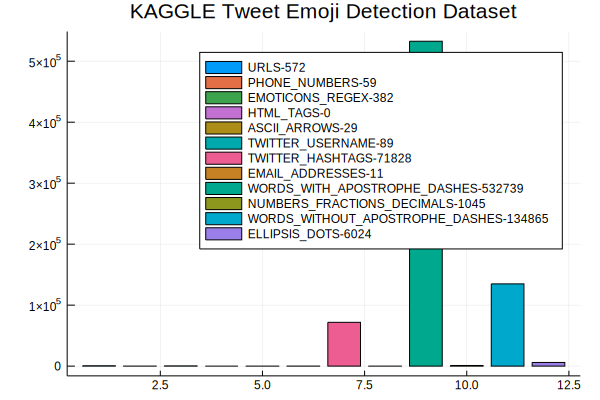

In [27]:
###########################################################################

################# Count on KAGGLE Emoji Competition Dataset ###############

###########################################################################

reset_parameter(parameter, params_list)

for tweet in KAGGLE_Tweets_Emoji_Competition
    tokens = tweet_tokenize(tweet,strip_handle=true,reduce_len=true)
    cnt(tokens, parameter, params_list)
end

println(parameter)
bar(x_label, eval(frequency_list), label=[m*"-"*string(parameter[m]) for m in params_list], title = "KAGGLE Tweet Emoji Detection Dataset")

Dict{String,Number}("ASCII_ARROWS"=>0,"PHONE_NUMBERS"=>78,"TWITTER_USERNAME"=>121,"HTML_TAGS"=>0,"TWITTER_HASHTAGS"=>2805,"URLS"=>3033,"ELLIPSIS_DOTS"=>332,"EMAIL_ADDRESSES"=>736,"WORDS_WITH_APOSTROPHE_DASHES"=>74322,"EMOTICONS_REGEX"=>181,"WORDS_WITHOUT_APOSTROPHE_DASHES"=>18503,"NUMBERS_FRACTIONS_DECIMALS"=>247)


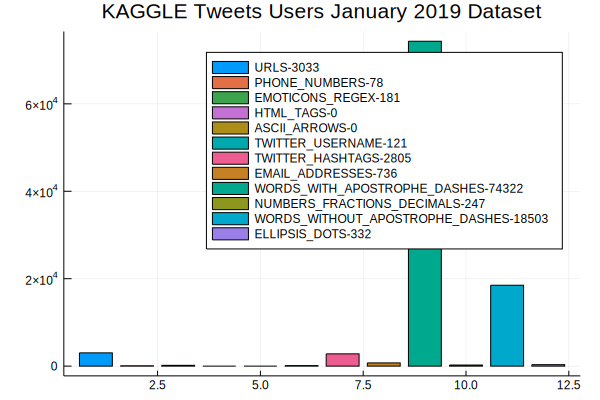

In [26]:
###########################################################################

############## Count on KAGGLE Tweets Users January 2019 Dataset ##########

###########################################################################

reset_parameter(parameter, params_list)

for tweet in KAGGLE_Tweets_User_Jan
    tokens = tweet_tokenize(tweet,strip_handle=true,reduce_len=true)
    cnt(tokens, parameter, params_list)
end
println(parameter)
bar(x_label, eval(frequency_list), label=[m*"-"*string(parameter[m]) for m in params_list], title = "KAGGLE Tweets Users January 2019 Dataset")

Dict{String,Number}("ASCII_ARROWS"=>1,"PHONE_NUMBERS"=>0,"TWITTER_USERNAME"=>0,"HTML_TAGS"=>0,"TWITTER_HASHTAGS"=>0,"URLS"=>0,"ELLIPSIS_DOTS"=>0,"EMAIL_ADDRESSES"=>0,"WORDS_WITH_APOSTROPHE_DASHES"=>16,"EMOTICONS_REGEX"=>0,"WORDS_WITHOUT_APOSTROPHE_DASHES"=>4,"NUMBERS_FRACTIONS_DECIMALS"=>0)


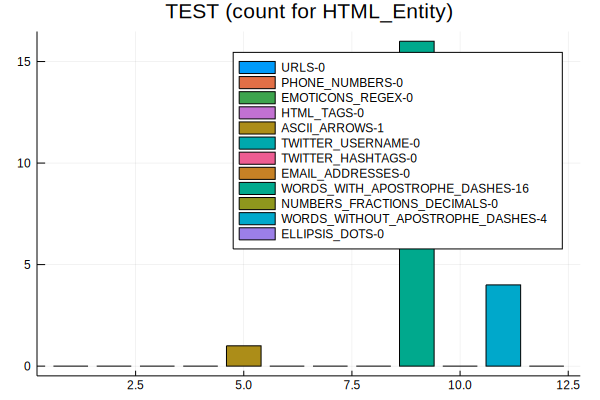

In [31]:
############### Testing with self made strings #####################

reset_parameter(parameter, params_list)

tokens = tweet_tokenize("&#916; Check if the count thing works for Base10 . This one too Hexa Base -> &#x394; . Also the windows one - &#130;",strip_handle=true,reduce_len=true)
cnt(tokens, parameter, params_list)
println(parameter) # NOTE : for token &#130; above, it uses both "Entity_Base_10" as well as "Entity_WINDOWS_1252"
bar(x_label, eval(frequency_list), label=[m*"-"*string(parameter[m]) for m in params_list], title = "TEST (count for HTML_Entity)")